In [1]:
import random

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams["font.size"] = 22
plt.rcParams['axes.facecolor'] = 'white'

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.metrics import classification_report, roc_auc_score

import uproot 
import awkward as ak


In [2]:
file = "/home/dejavu/Projects/Samples/qgcal/merged_hist_weight.root"
merged_file = uproot.open(file)

In [3]:
branch_names = ["total_weight", "pu_weight", "mconly_weight", "jet_fire", "jet_pt", "jet_eta", "jet_nTracks", "jet_trackWidth", "jet_trackC1", "jet_trackBDT", "jet_PartonTruthLabelID"]
branches = merged_file["nominal"].arrays(branch_names)

## Event trigger and leadjing jets selection

In [4]:
print("Before applying event trigger:")
print(branches.type)

Before applying event trigger:
148462568 * {"total_weight": float32, "pu_weight": float32, "mconly_weight": float32, "jet_fire": bool, "jet_pt": var * float32, "jet_eta": var * float32, "jet_nTracks": var * float32, "jet_trackWidth": var * float32, "jet_trackC1": var * float32, "jet_trackBDT": var * float32, "jet_PartonTruthLabelID": var * int32}


In [5]:
branches = branches[branches["jet_fire"]==1]

In [6]:
print("after applying event trigger:")
print(branches.type)

after applying event trigger:
70890262 * {"total_weight": float32, "pu_weight": float32, "mconly_weight": float32, "jet_fire": bool, "jet_pt": var * float32, "jet_eta": var * float32, "jet_nTracks": var * float32, "jet_trackWidth": var * float32, "jet_trackC1": var * float32, "jet_trackBDT": var * float32, "jet_PartonTruthLabelID": var * int32}


In [7]:
# select all the jets from all the events 
jet_properties = branches[branch_names[4:]]

In [8]:
# select first leading jets in the events
dijet_properties = jet_properties[:,:2]

In [9]:
# Get the total_weigt information
total_weight = branches["total_weight"]

In [13]:
# flatten jet
df = ak.to_pandas(dijet_properties)
dijet_sample = df.to_numpy()

In [14]:
df.head()

jet_pt   jet_eta  jet_nTracks  jet_trackWidth  \
entry subentry                                                        
0     0         414797.78125 -0.230682         21.0        0.092207   
      1         285410.25000  0.862495         15.0        0.023376   
1     0         513987.34375 -0.106736         23.0        0.056083   
      1         486735.90625  0.327877         27.0        0.073385   
2     0         503916.15625 -1.689755         21.0        0.075387   

                jet_trackC1  jet_trackBDT  jet_PartonTruthLabelID  
entry subentry                                                     
0     0            0.275592      0.148888                      -1  
      1            0.134707     -0.108245                      -1  
1     0            0.249986      0.175032                      21  
      1            0.287563      0.279771                      -1  
2     0            0.251628      0.084369                      21

In [12]:
dijet_properties.type

70890262 * {"jet_pt": var * float32, "jet_eta": var * float32, "jet_nTracks": var * float32, "jet_trackWidth": var * float32, "jet_trackC1": var * float32, "jet_trackBDT": var * float32, "jet_PartonTruthLabelID": var * int32}

In [15]:
# repeat the weight to match the first two jets
total_weight_jets = np.repeat(total_weight, 2)
total_weight_jets = total_weight_jets.to_numpy()


In [17]:
dijets = np.hstack((dijet_sample, total_weight_jets[:, None]))

In [18]:
np.save("dijets.npy", dijets)

## Draw Components

In [19]:
def draw_components(labels):
    components = np.bincount(labels.astype(int)+1)
    partonID = ['others', 'd', 'u', 's', 'c', 'b', 'gluon']
    plt.bar(partonID, components[components.nonzero()])
    plt.xlabel('Jet Category')
    plt.ylabel('Number of jets')
    plt.text(4, 0.5, f"num. of jets: {len(labels)} ")
    plt.savefig("jet_components")

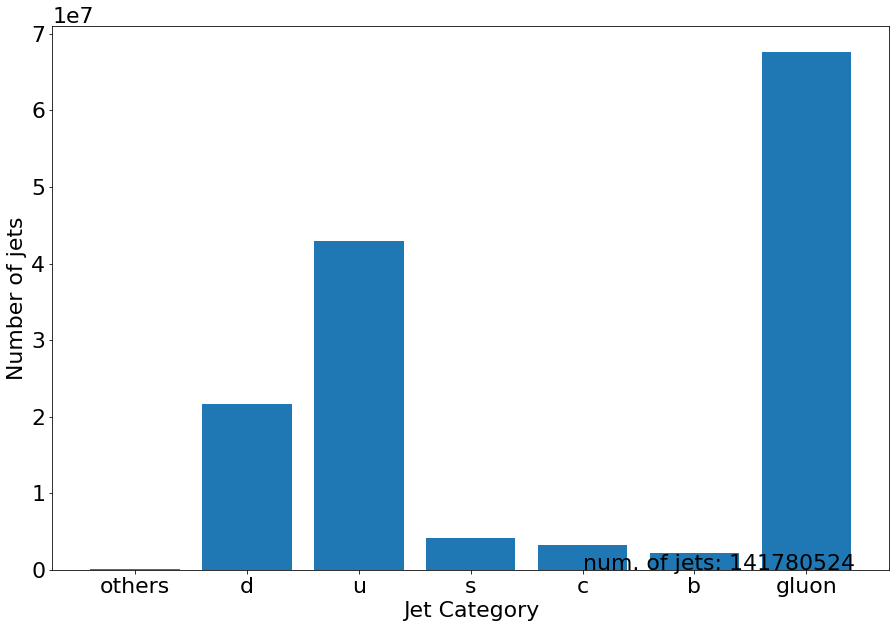

In [40]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams["font.size"] = 22
draw_components(dijets[:,-2])

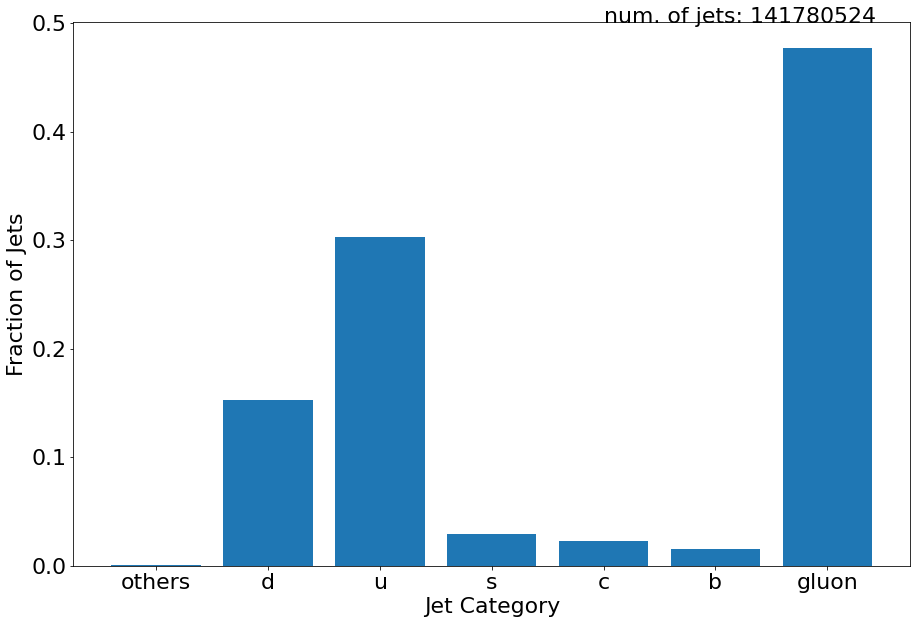

In [41]:
def draw_components_norm(labels):
    components = np.bincount(labels.astype(int)+1)
    partonID = ['others', 'd', 'u', 's', 'c', 'b', 'gluon']
    plt.bar(partonID, components[components.nonzero()]/len(labels))
    plt.xlabel('Jet Category')
    plt.ylabel('Fraction of Jets')
    plt.text(4, 0.5, f"num. of jets: {len(labels)} ")
    plt.savefig("jet_components_norm")
    # plt.show()
draw_components_norm(dijets[:,-2])

## Draw distribution (without weight cut)

In [57]:
user_range = [(20, 2000), (-3, 3), (0, 100), (-0.1, 0.4), (-0.1, 0.5), (-1.0, 1.0)]
user_xlabel = ["Jet $p_{\mathrm{T}}$ [GeV]", "$\eta$", "Number of tracks", "$W_{jet}$", "$C_1$", "BDT Score"]
user_filename = ["dis_jetpt", "dis_eta", "dis_ntracks", "dis_width", "dis_c1", "dis_bdt"]
user_scale = [1e3, 1, 1, 1, 1, 1]

In [60]:
def draw_distribution(variable, range=(0, 100), n_bins=100, weight = 1.0, xlabel='xlabel', ylabel='Number of jets', save = False, fig_name='figure', scale =1.0):
    fig, ax = plt.subplots()
    bins = np.linspace(range[0], range[1], n_bins)
    ax.hist(variable/scale, bins, weights = weight, alpha=0.5, color = 'blue')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if save:
        fig.savefig(fig_name, transparent=False)
    else:
        fig.show()
    

In [30]:
weights_wo_cuts = np.copy(dijets[:,-1])

Drawing jet_pt
Drawing jet_eta
Drawing jet_nTracks
Drawing jet_trackWidth
Drawing jet_trackC1
Drawing jet_trackBDT


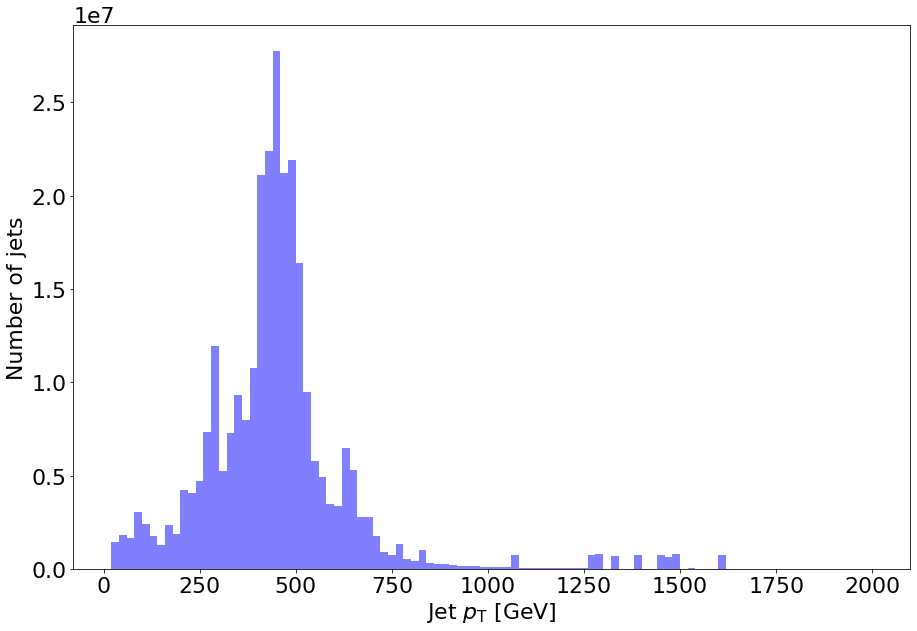

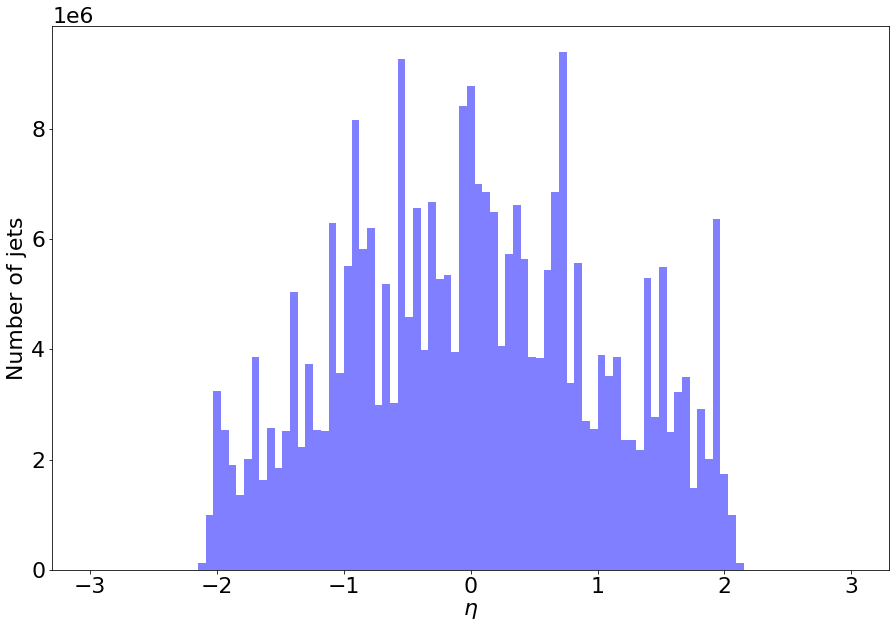

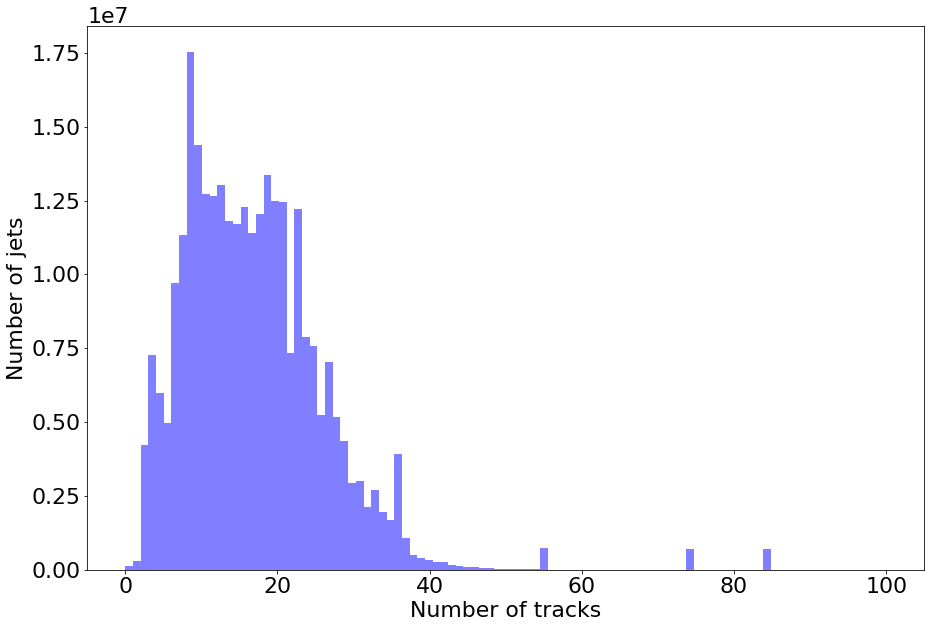

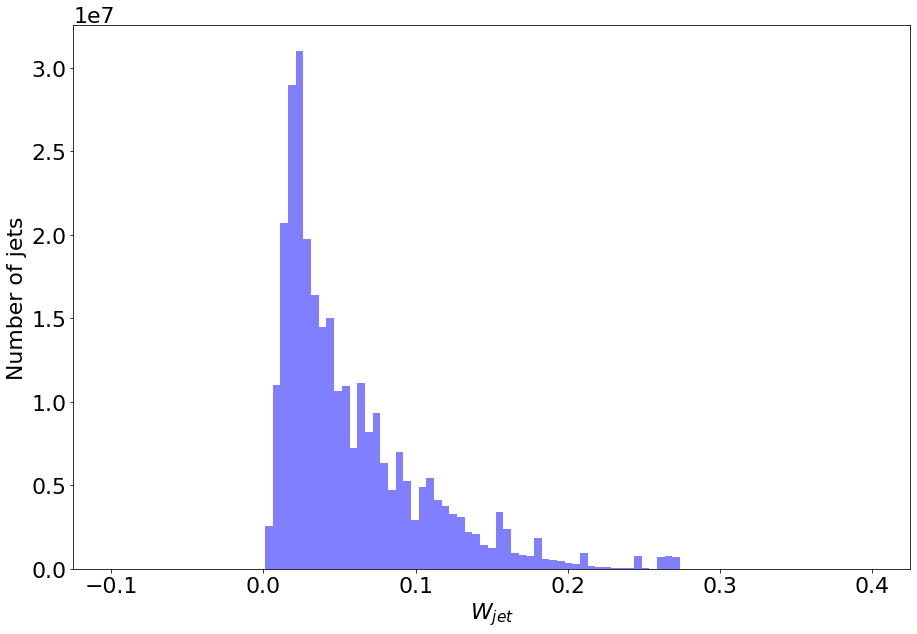

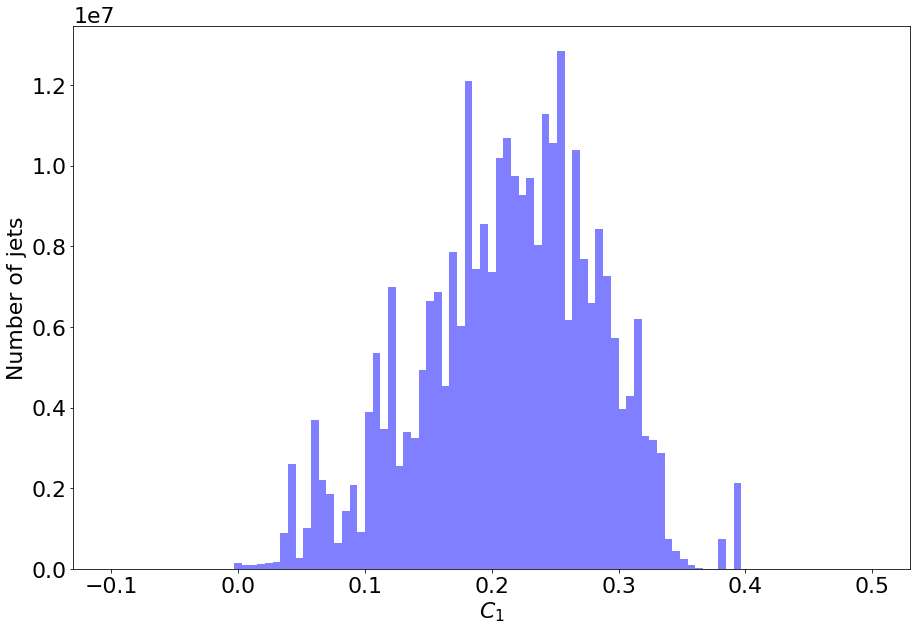

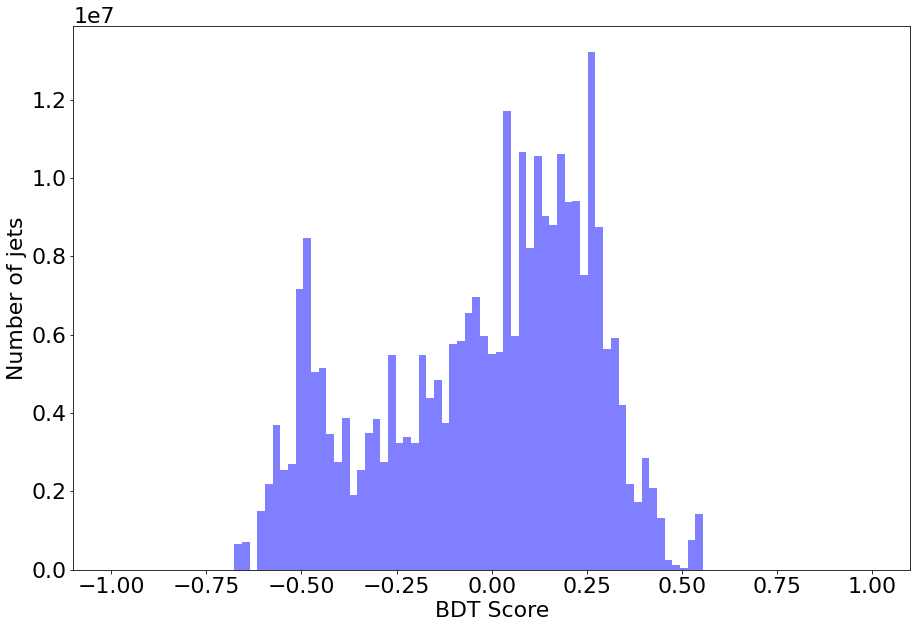

In [61]:
for i in range(0,6):
    print(f"Drawing {branch_names[4+i]}")
    draw_distribution(dijets[:,i], scale=user_scale[i], range=user_range[i], weight=weights_wo_cuts, xlabel=user_xlabel[i], save = True, fig_name=user_filename[i]+"_wo_cut")

## Draw distribution (with weight cut)

In [34]:
weight_idx = np.where(np.abs(dijets[:,-1]) > 100)[0]
dijets[:,-1][weight_idx] = 1.0

Drawing jet_pt
Drawing jet_eta
Drawing jet_nTracks
Drawing jet_trackWidth
Drawing jet_trackC1
Drawing jet_trackBDT


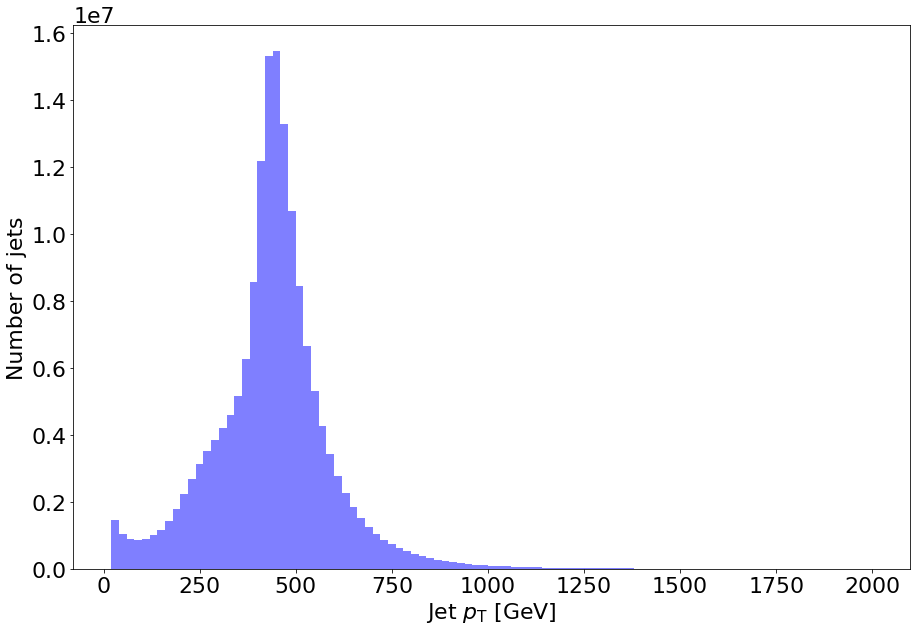

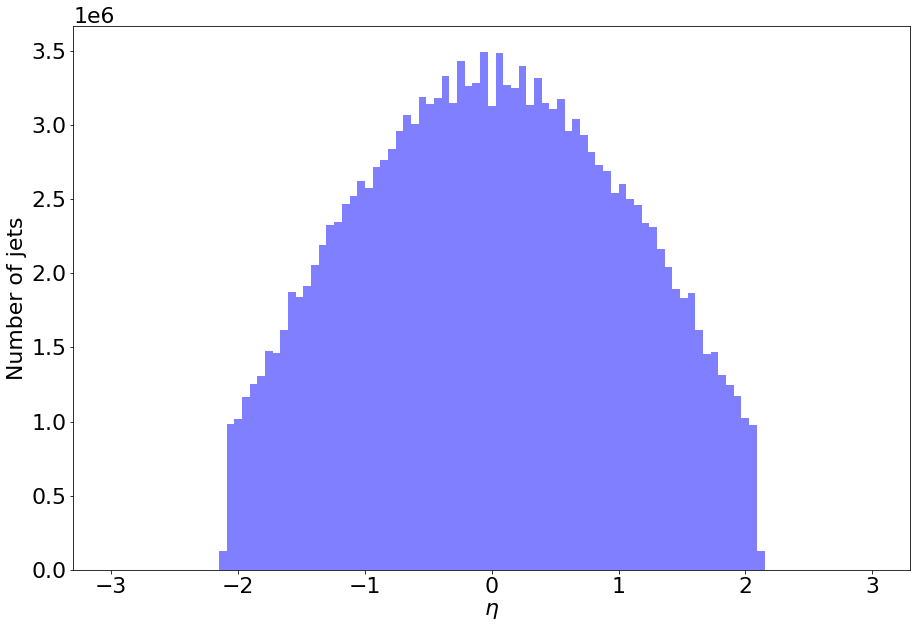

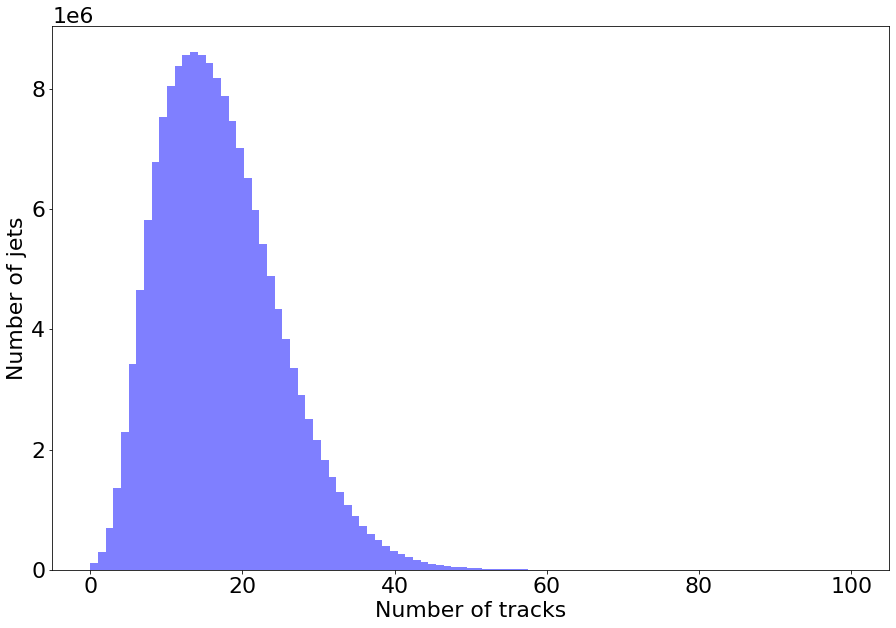

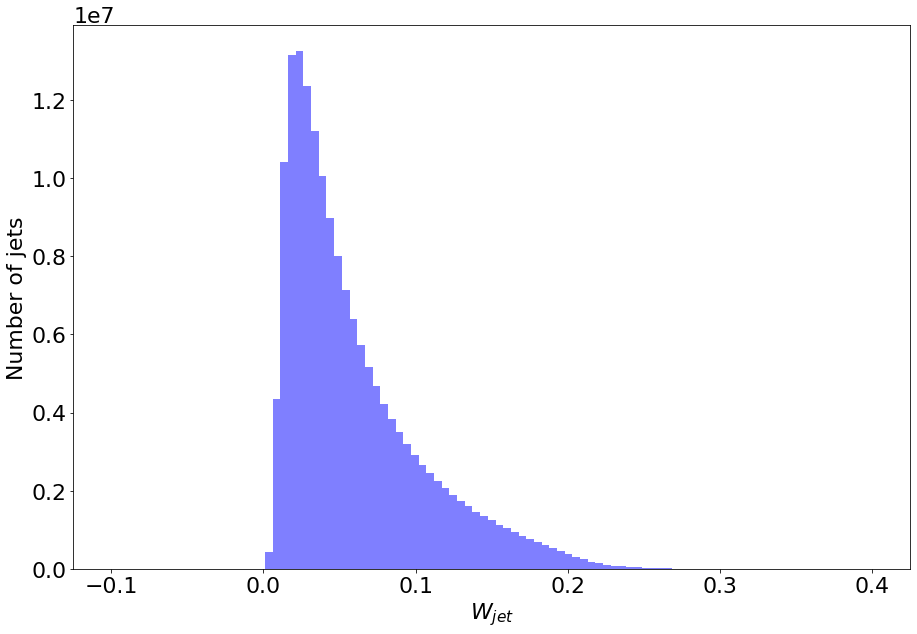

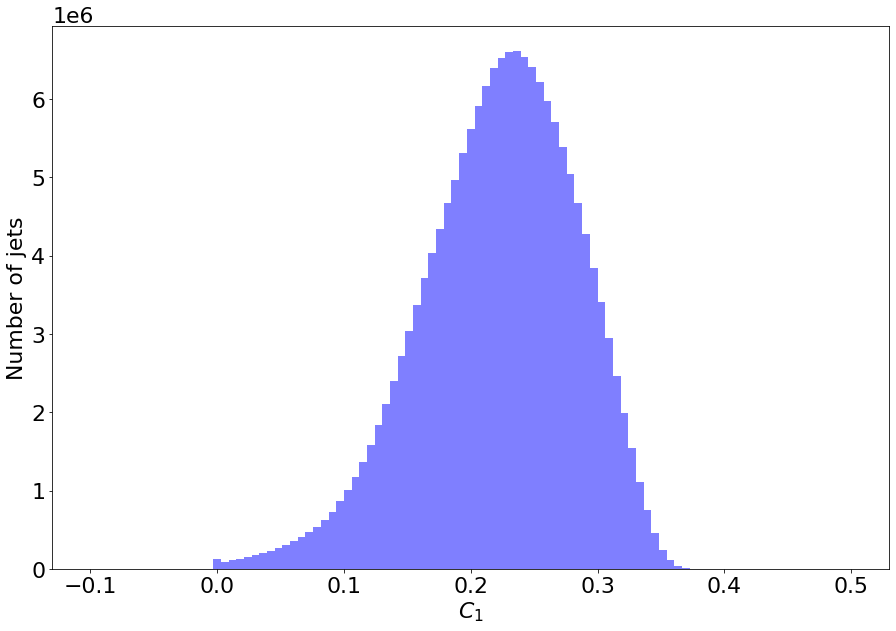

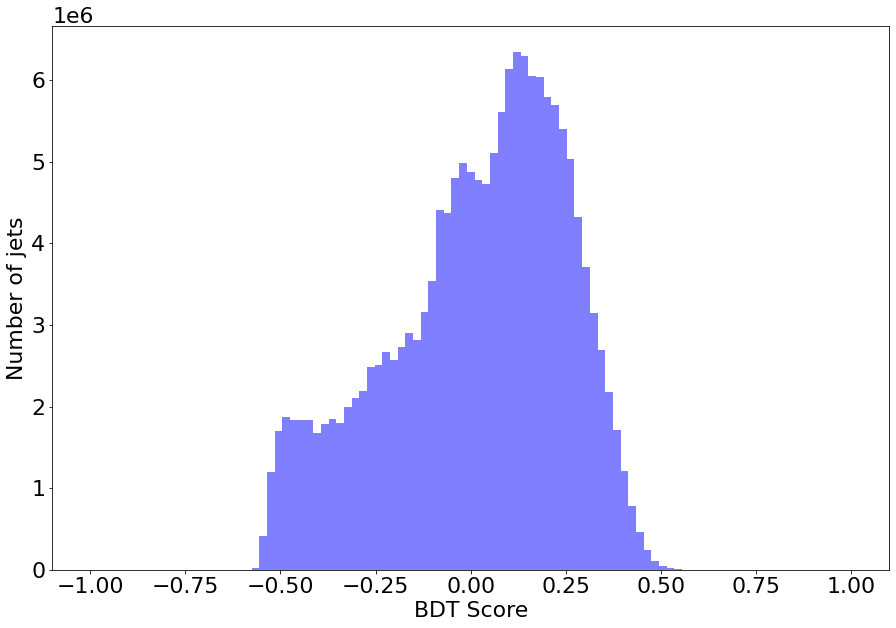

In [62]:
for i in range(0,6):
    print(f"Drawing {branch_names[4+i]}")
    draw_distribution(dijets[:,i], scale=user_scale[i], range=user_range[i], weight=dijets[:,-1], xlabel=user_xlabel[i], save = True, fig_name=user_filename[i]+"_weight_cut")

## Quark vs Gluon
For the following we are always using the weights after 100 cut.

In [50]:
gluon_idx = np.where(dijets[:,-2]==21)
light_quark_idx = np.where((dijets[:,-2]==0) | (dijets[:,-2]==1)| (dijets[:,-2]==2))

In [56]:
print(f"Number of gluons: {len(gluon_idx[0])}")
print(f"Number of light quarks: {len(light_quark_idx[0])}")

Number of gluons: 67618360
Number of light quarks: 64582119


In [51]:
gluon = dijets[gluon_idx]
quark = dijets[light_quark_idx]

In [52]:
def draw_distribution_signal_bkg(
    variable_gluon, variable_quark, weight_gluon, weight_quark, 
    range=(0, 100), n_bins=100, density = False, 
    xlabel='xlabel', ylabel='Number of jets', save = False, 
    fig_name='figure', scale =1.0
    ):
    bins = np.linspace(range[0], range[1], n_bins)
    plt.hist(variable_gluon/scale, bins, weights = weight_gluon, density = density, alpha=0.5, label='gluon', color = 'blue')
    plt.hist(variable_quark/scale, bins, weights = weight_quark, density = density, alpha=0.5, label='quark', color = 'red')
    plt.legend(loc='upper right')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if save:
        if density:
            plt.savefig(fig_name+"_q_vs_g_norm")
        else:
            plt.savefig(fig_name+"_q_vs_g")
        plt.show()
    else:
        plt.show()
    

### Variables with Normalization

Drawing jet_pt


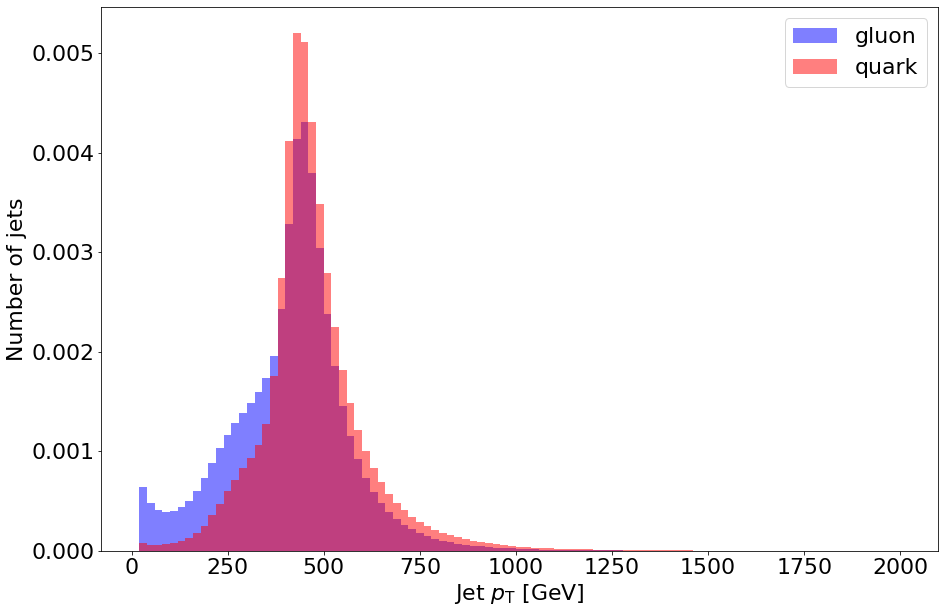

Drawing jet_eta


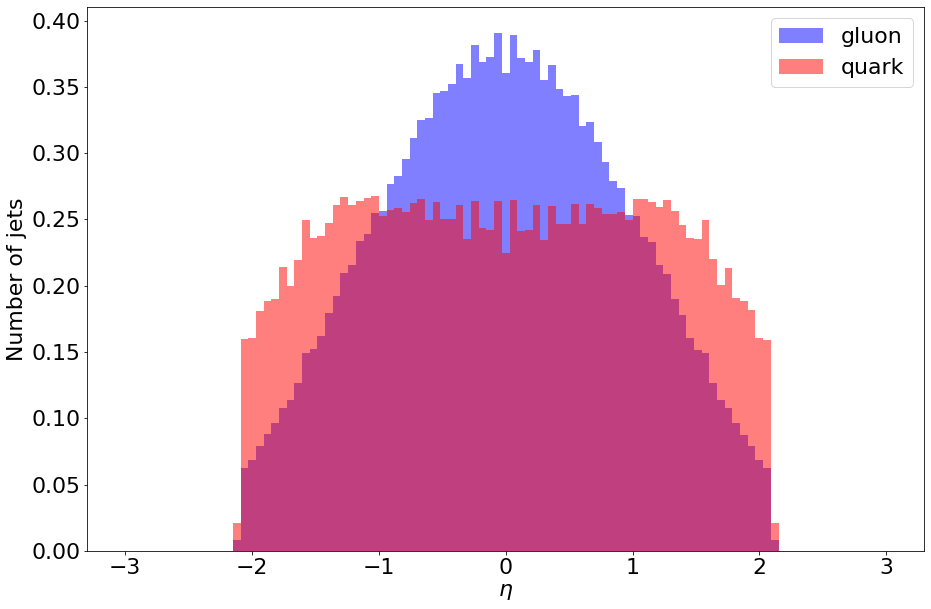

Drawing jet_nTracks


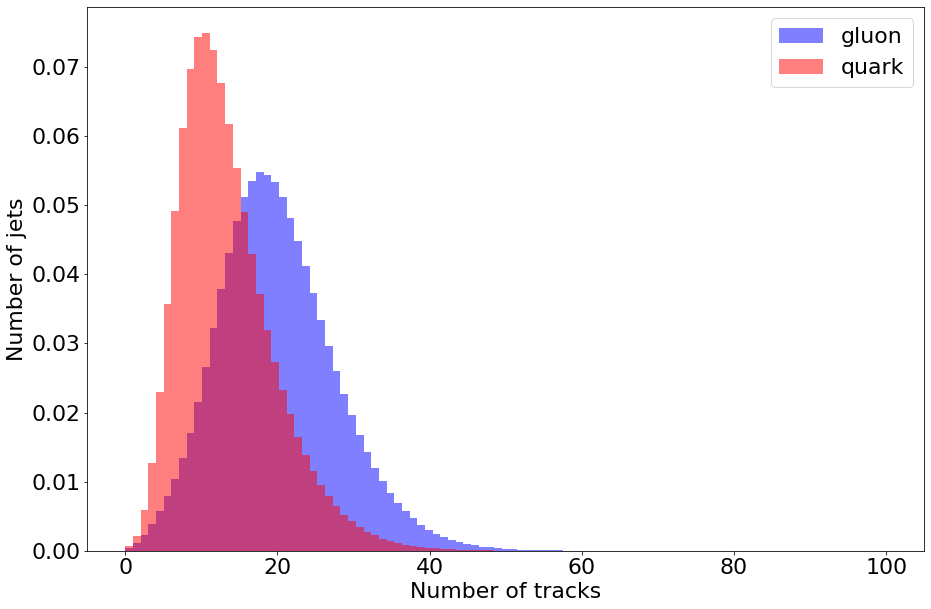

Drawing jet_trackWidth


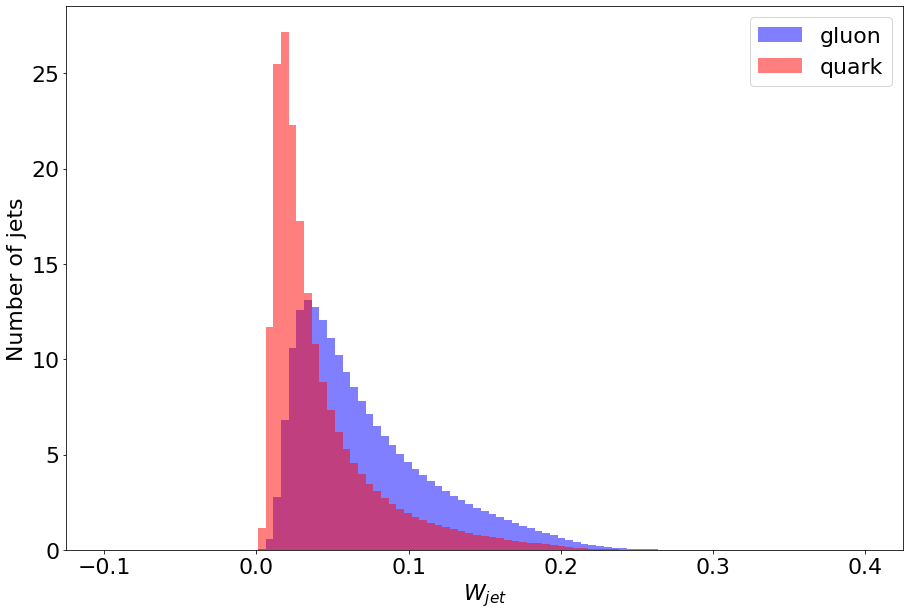

Drawing jet_trackC1


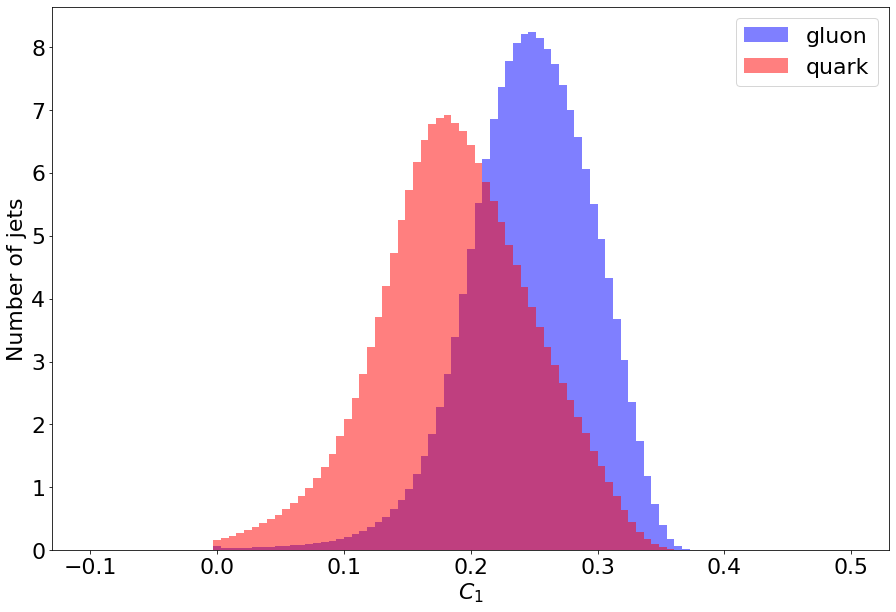

Drawing jet_trackBDT


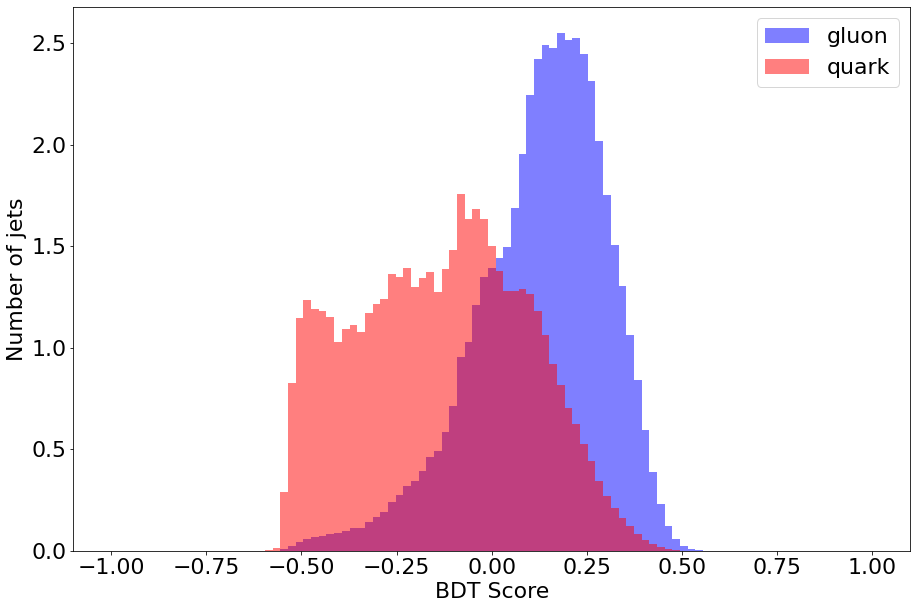

In [63]:
for i in range(0,6):
    print(f"Drawing {branch_names[4+i]}")
    draw_distribution_signal_bkg(variable_gluon = gluon[:,i], variable_quark=quark[:,i], 
                                 weight_gluon=gluon[:,-1], weight_quark=quark[:,-1],
                                 range=user_range[i], xlabel=user_xlabel[i], scale=user_scale[i],
                                 fig_name=user_filename[i], density = True, save=True)

### Variables Without Normalization

Drawing jet_pt


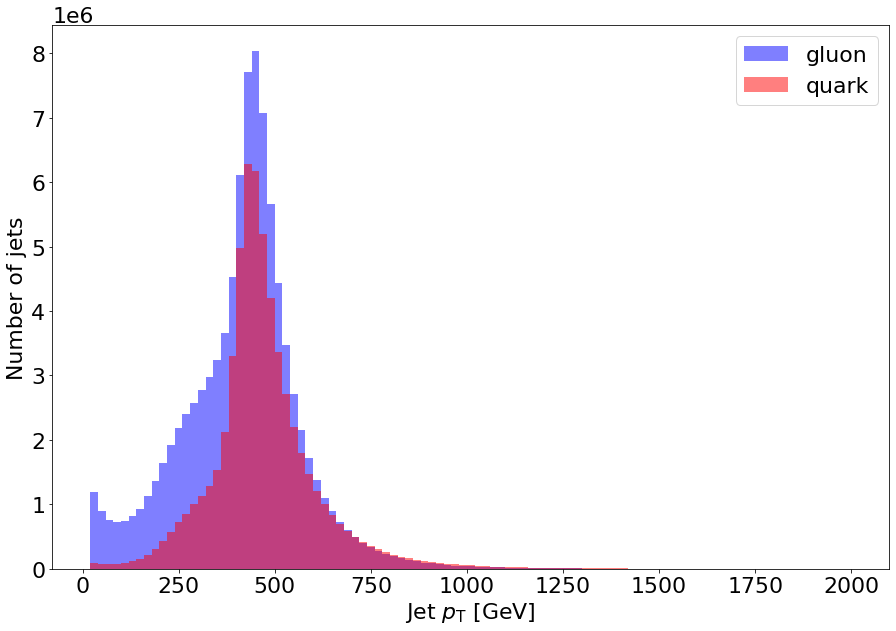

Drawing jet_eta


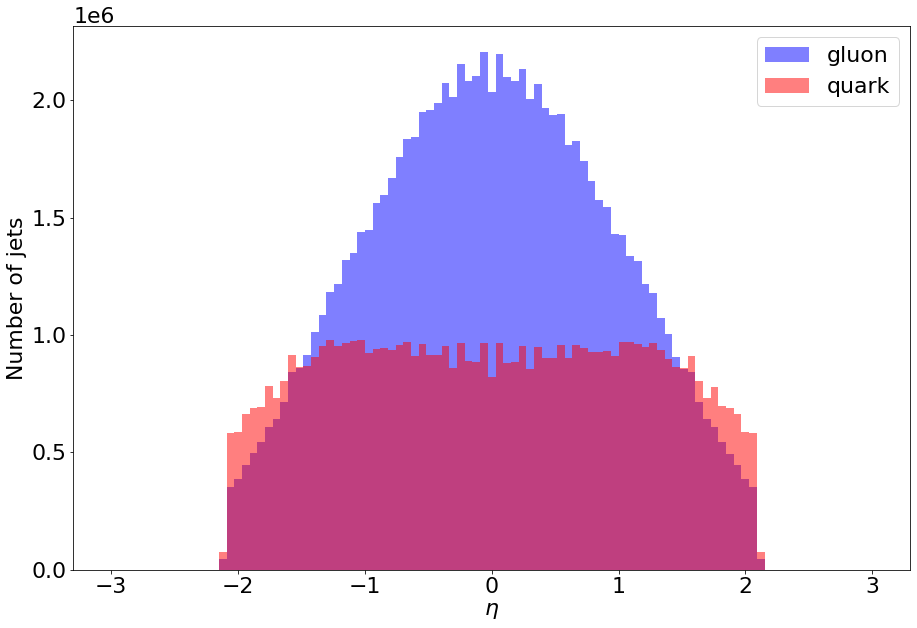

Drawing jet_nTracks


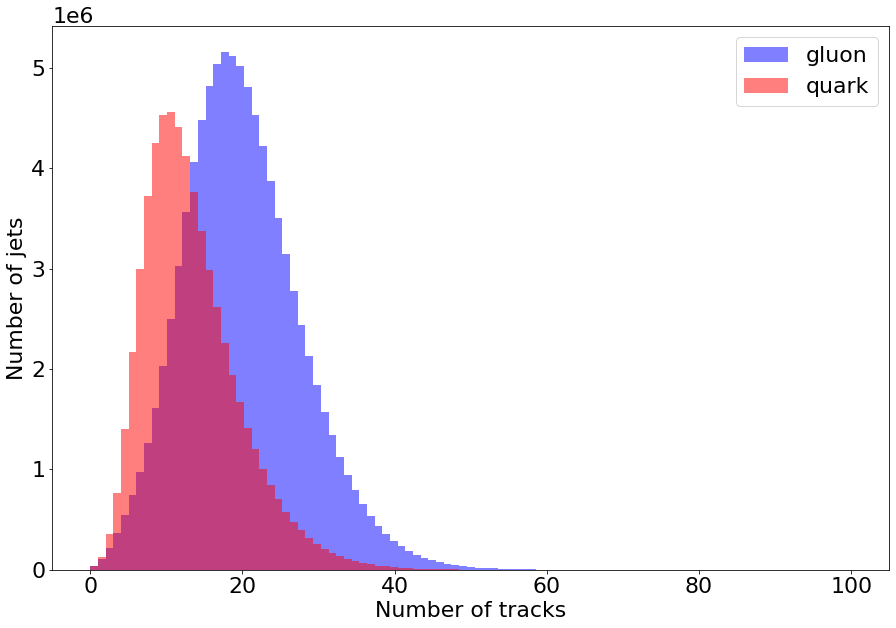

Drawing jet_trackWidth


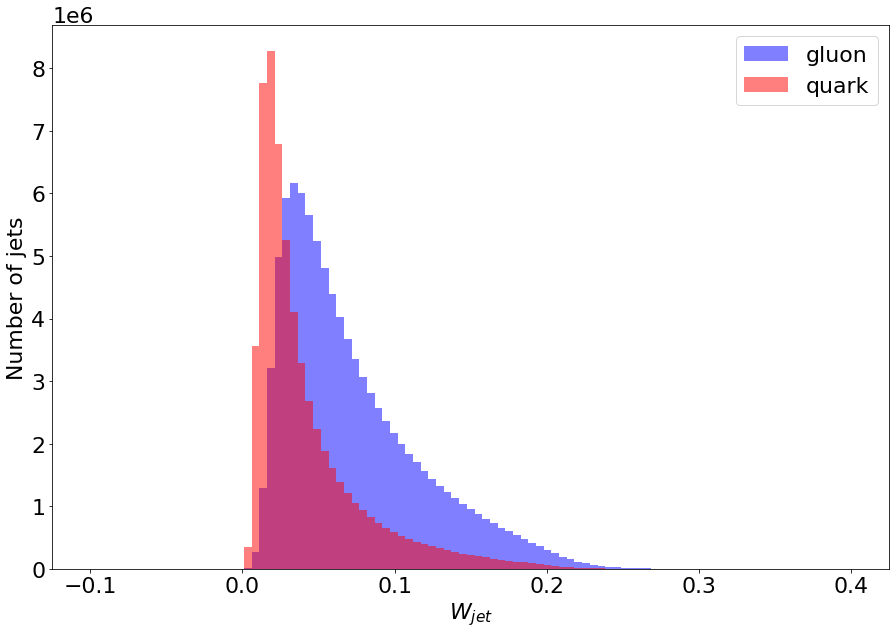

Drawing jet_trackC1


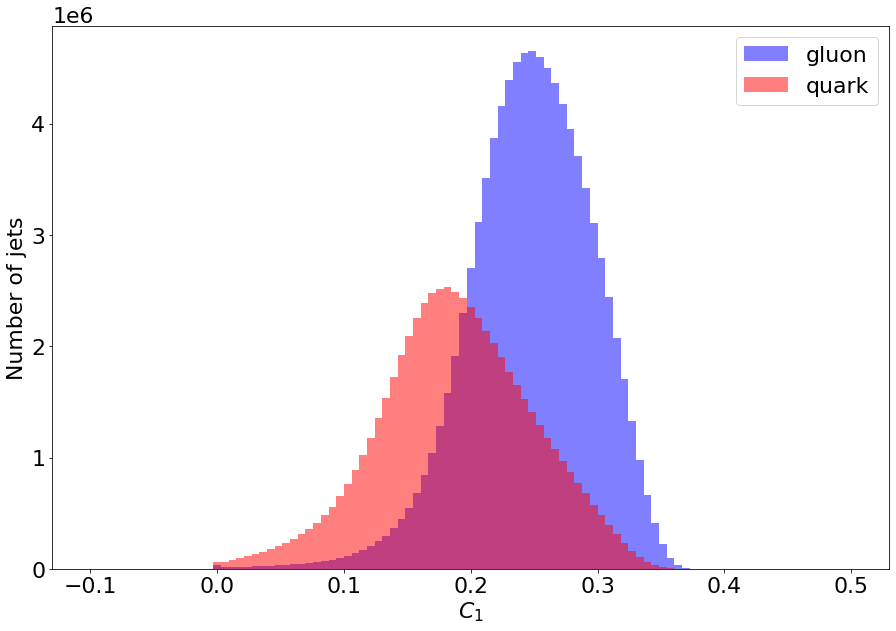

In [64]:
for i in range(0,5):
    print(f"Drawing {branch_names[4+i]}")
    draw_distribution_signal_bkg(variable_gluon = gluon[:,i], variable_quark=quark[:,i], 
                                 weight_gluon=gluon[:,-1], weight_quark=quark[:,-1],
                                 range=user_range[i], xlabel=user_xlabel[i], scale=user_scale[i],
                                 fig_name=user_filename[i], density = False, save=True)